<a href="https://colab.research.google.com/github/ucaokylong/Tabular_data/blob/main/Anomaly_Detection_m2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [ ]:
!gdown --id 1JDd8GwKXCf1Wk9gxJeEHyGXAJw-M6zH8
!gdown --id 1tsha38II30H6DJco8GV6-iYGSvKgg60d

In [ ]:
small_noise_url = "art_daily_small_noise.csv"
df_small_noise = pd.read_csv(small_noise_url, parse_dates=True, index_col="timestamp")
print(df_small_noise.shape)

daily_jumpsup_url = "art_daily_jumpsup.csv"
df_daily_jumpsup = pd.read_csv(daily_jumpsup_url, parse_dates=True, index_col="timestamp")
print(df_daily_jumpsup.shape)

(4032, 1)
(4032, 1)


## Quick look at the data

In [ ]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


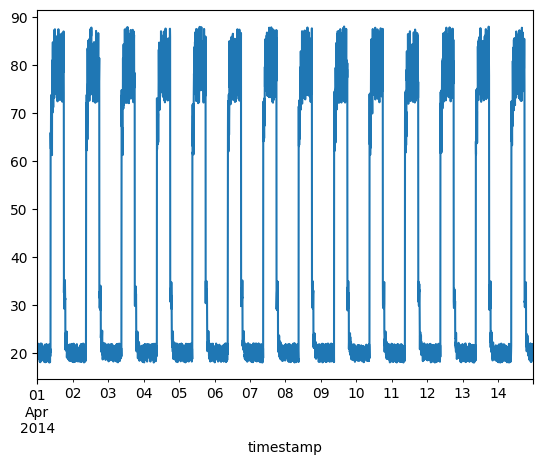

In [ ]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

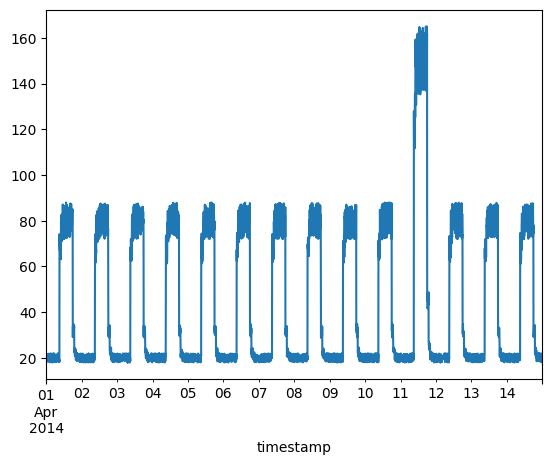

In [ ]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [ ]:
# Normalize
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [ ]:
model = keras.Sequential([layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [ ]:
history = model.fit(x_train,x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")])

Epoch 1/50
27/27 [==============================] - 2s 51ms/step - loss: 0.5591 - val_loss: 0.0838
Epoch 2/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0783 - val_loss: 0.0400
Epoch 3/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0563 - val_loss: 0.0343
Epoch 4/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0479 - val_loss: 0.0301
Epoch 5/50
27/27 [==============================] - 1s 39ms/step - loss: 0.0421 - val_loss: 0.0267
Epoch 6/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0376 - val_loss: 0.0253
Epoch 7/50
27/27 [==============================] - 1s 42ms/step - loss: 0.0336 - val_loss: 0.0243
Epoch 8/50
27/27 [==============================] - 1s 40ms/step - loss: 0.0302 - val_loss: 0.0232
Epoch 9/50
27/27 [==============================] - 1s 41ms/step - loss: 0.0277 - val_loss: 0.0222
Epoch 10/50
27/27 [==============================] - 1s 43ms/step - loss: 0.0256 - val_loss: 0.0218
Epoch 11/

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

118/118 [==============================] - 1s 6ms/step


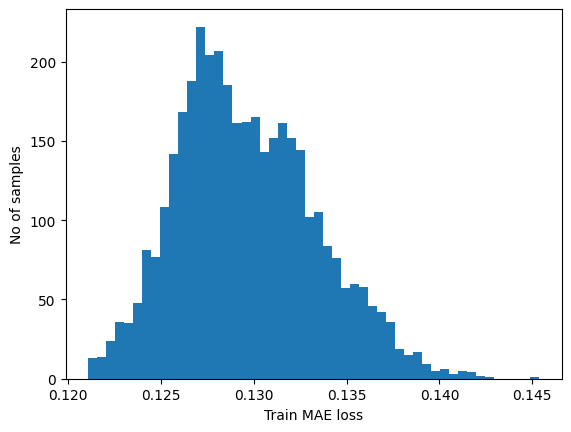

Reconstruction error threshold:  0.14537304810527052


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction


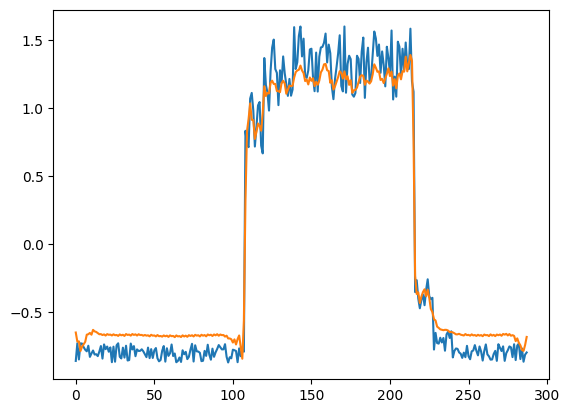

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

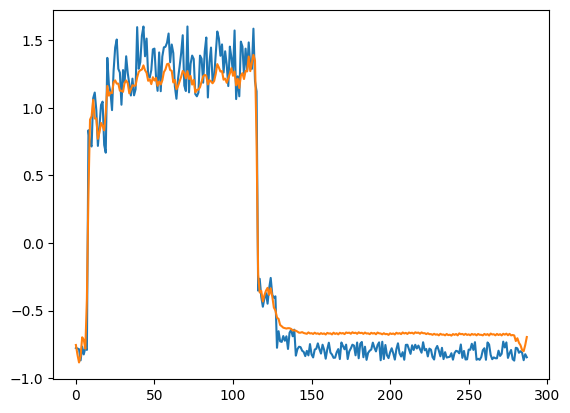

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[100])
plt.plot(x_train_pred[100])
plt.show()

### Prepare test data

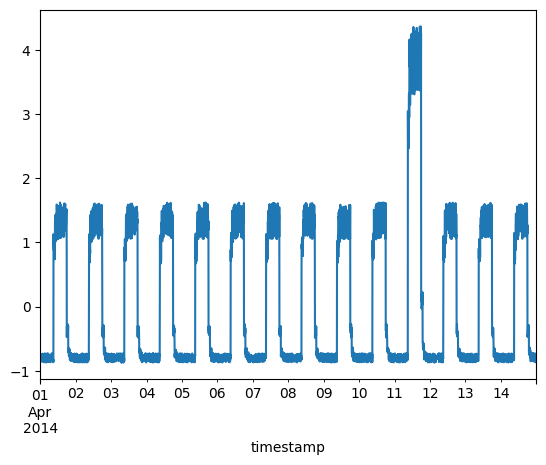

Test input shape:  (3745, 288, 1)


In [ ]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

118/118 [==============================] - 1s 6ms/step


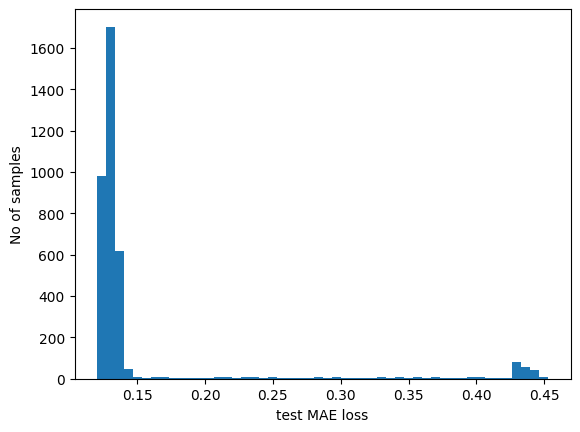

In [ ]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [ ]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  402
Indices of anomaly samples:  (array([1650, 1652, 1654, 1658, 1659, 2519, 2523, 2701, 2702, 2703, 2704,
       2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715,
       2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726,
       2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx+1]):
        anomalous_data_indices.append(data_idx)

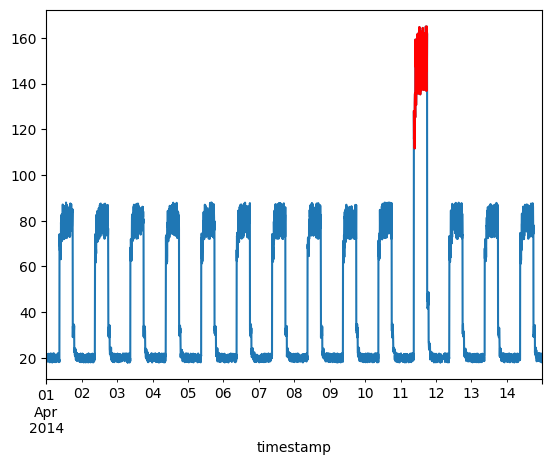

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [ ]:
i = anomalous_data_indices[0]
print(i, test_mae_loss[i])

2988 0.41541130434594975
